In [195]:
#install some necessary libraries
# !pip install pandas sklearn xgboost

In [196]:
# import the libraries we'll need
import pandas as pd
import seaborn as sns
import numpy as np
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
import matplotlib.pyplot as plt

In [197]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


In [198]:

# df['request.url'] =  df['request.url'].str.slice(22)

In [199]:
def check_for_Log4j(row):
    if row.str.contains('jndi:').any():
        return 1
    else:
        return 0

df['Log4j'] = df.apply(lambda row: check_for_Log4j(row), axis=1)

In [200]:
def check_for_SQL_injection(row):
    if 'SELECT' in row["request.url"] or '%20or%20' in row["request.url"]:
        return 1
    else:
        return 0

df['SQL'] = df.apply(lambda row: check_for_SQL_injection(row), axis=1)

In [201]:
def check_for_RCE(row):
    """
    __globals__ attribute refers to a dictionary containing the global variables defined in the current namespace.
    can allow code to access and manipulate global variables in unintended ways.
    __builtins__ attribute refers to a dictionary containing the built-in functions and variables defined in Python.
    can allow code to access and manipulate built-in functions in unintended ways
    %3C/script%3E is a URL-encoded string that represents the characters </script>.
    __import__ attributes to import the os module and execute the system function.
    """
    if '__globals__' in row['request.url']\
        or "%3C/script%3E" in row['request.url']\
            or "__import__('os')" in row['request.url']\
                or '__builtins__' in row['request.url']:
        return 1
    else:
        return 0

df['RCE'] = df.apply(lambda row: check_for_RCE(row), axis=1)

In [202]:
# def check_for_Directory_Traversal(row):
#     if '.txt not found' in row["response.body"]:
#         return 1
#     else:
#         return 0

# df['Directory_Traversal'] = df.apply(lambda row: check_for_Directory_Traversal(row), axis=1)

def check_for_Directory_Traversal(row):
    """
    an attacker tries to access sensitive files or a restricted directory on the server
    """
    if '../secrets.txt' in row["request.url"]\
            or '../etc/passwd.txt' in row["request.url"]\
                or ('../../../' in row["request.url"] and ('error' in row["response.body"])):
        return 1
    else:
        return 0

df['Directory_Traversal'] = df.apply(lambda row: check_for_Directory_Traversal(row), axis=1)

In [203]:
def check_for_Cookie_injection(row):
    #print(row)
    #if row["request.url"].str.contains('cookielogin'):
    #if row.str.contains('cookielogin'):
    if 'cookielogin' in row["request.url"]:
        return 1
    else:
        return 0

df['Cookie_Injection'] = df.apply(lambda row: check_for_Cookie_injection(row), axis=1)

In [204]:
def check_for_Log_Forge(row):
    if '%20user%20' in row["request.url"]:
        return 1
    else:
        return 0

df['Log_Forge'] = df.apply(lambda row: check_for_Log_Forge(row), axis=1)

In [205]:
def check_for_XSS(row):
    if ('script' in row["request.url"] and 'http://127.0.0.1:5000/forum?message=' in row["request.url"]) or row["request.url"] == 'http://127.0.0.1:5000/forum':
        return 1
    else:
        return 0

df['XSS'] = df.apply(lambda row: check_for_XSS(row), axis=1)

In [206]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']
df.drop('request.Attack_Tag', axis=1, inplace=True)


In [207]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,0,0,1,0,0,0,0,RCE
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,0,0,0,0,0,0,0,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,0,0,0,0,0,0,0,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,0,0,0,0,0,0,0,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,0,0,0,0,0,0,0,Benign


In [208]:
df.head(2)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,0,0,1,0,0,0,0,RCE
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,0,0,0,0,0,0,0,Benign


In [209]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Accept',
                'request.headers.Accept-Language',
                'request.headers.Date',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'response.headers.Location',
                'request.headers.Set-Cookie',
                'request.method',
                'request.url',
                'response.status',
                'response.body',
                'request.headers.Content-Length',
                'request.headers.Cookie',
                'response.headers.Set-Cookie',
                'response.headers.Content-Length',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [

                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'request.headers.Host',
                    'request.headers.Date',
                    'request.headers.Sec-Fetch-User',
                    'response.headers.Content-Type',
                    'request.headers.User-Agent',
                    'request.headers.Connection'
                    ]

CTOR2 = [   'request.headers.Cache-Control',
            'request.headers.Sec-Ch-Ua-Mobile',
            'request.headers.Upgrade-Insecure-Requests',
            'request.headers.Sec-Ch-Ua-Platform']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    
    return df

df = vectorize_df(df)
df.head()

,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,Log4j,SQL,RCE,Directory_Traversal,Cookie_Injection,Log_Forge,XSS,attack_type
0,1,0,2,1,1,1,118596,0,26609,0,1226,200,246,14,2,0,0,0,0,1,0,0,0,0,RCE
1,1,0,3,1,1,1,25005,0,8568,0,2047,200,246,14,2,0,0,0,0,0,0,0,0,0,Benign
2,1,0,4,1,2,1,69286,0,72516,0,2024,200,2934,14,2,0,0,0,0,0,0,0,0,0,Benign
3,1,0,4,1,2,1,8697,0,25950,0,2021,200,0,14,2,0,0,0,0,0,0,0,0,0,Benign
4,1,0,1,1,2,1,33091,0,51587,5,714,404,5865,14,2,0,0,0,0,0,0,0,0,0,Benign


In [210]:
# # Increase the size of the heatmap.
# plt.figure(figsize=(20, 20))
# # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
# heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

In [211]:
features_list = df.columns.to_list()
features_list.remove('attack_type')

# features_list = ['request.url', 'response.status_code', 'response.status', 'request.headers.User-Agent', 'response.headers.Content-Type', 'request.method', 'request.headers.Content-Length', 'response.headers.Content-Length']

print(features_list)

['request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'Log4j', 'SQL', 'RCE', 'Directory_Traversal', 'Cookie_Injection', 'Log_Forge', 'XSS']


In [212]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 24) (118995,)
(25505, 24) (25505,)


Counter({'RCE': 1612,
         'Benign': 128420,
         'SQL Injection': 3173,
         'Cookie Injection': 3257,
         'XSS': 3290,
         'LOG4J': 1578,
         'Log Forging': 1626,
         'Directory Traversal': 1544})

In [213]:
# Convert the labels to integers
AttackDict = {'Benign': 0, 'Cookie Injection': 1, 'Directory Traversal': 2, 'LOG4J': 3, 'Log Forging': 4, 'RCE': 5, 'SQL Injection': 6, 'XSS': 7}
y_train = [AttackDict[y] for y in y_train]
y_test = [AttackDict[y] for y in y_test]


In [214]:
# Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 6, 9],
#     'n_estimators': [10, 50, 100],
#     'learning_rate': [0.1, 0.5, 1]
# }

# # Create the XGBoost model
# model = xgb.XGBClassifier()

# # Create the grid search object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# # Fit the grid search object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print(grid_search.best_params_)

In [215]:
# define the parameters
params = {
    'booster': 'gbtree',
    'learning_rate': 0.55,
    'max_depth': 6,
    'n_estimators': 60, 
    'reg_lambda': 1
}

# create the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.55, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [216]:
# evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 1.00


              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     22667
           1    1.00000   1.00000   1.00000       575
           2    1.00000   1.00000   1.00000       272
           3    1.00000   1.00000   1.00000       278
           4    1.00000   1.00000   1.00000       287
           5    1.00000   1.00000   1.00000       285
           6    1.00000   1.00000   1.00000       560
           7    1.00000   1.00000   1.00000       581

    accuracy                        1.00000     25505
   macro avg    1.00000   1.00000   1.00000     25505
weighted avg    1.00000   1.00000   1.00000     25505



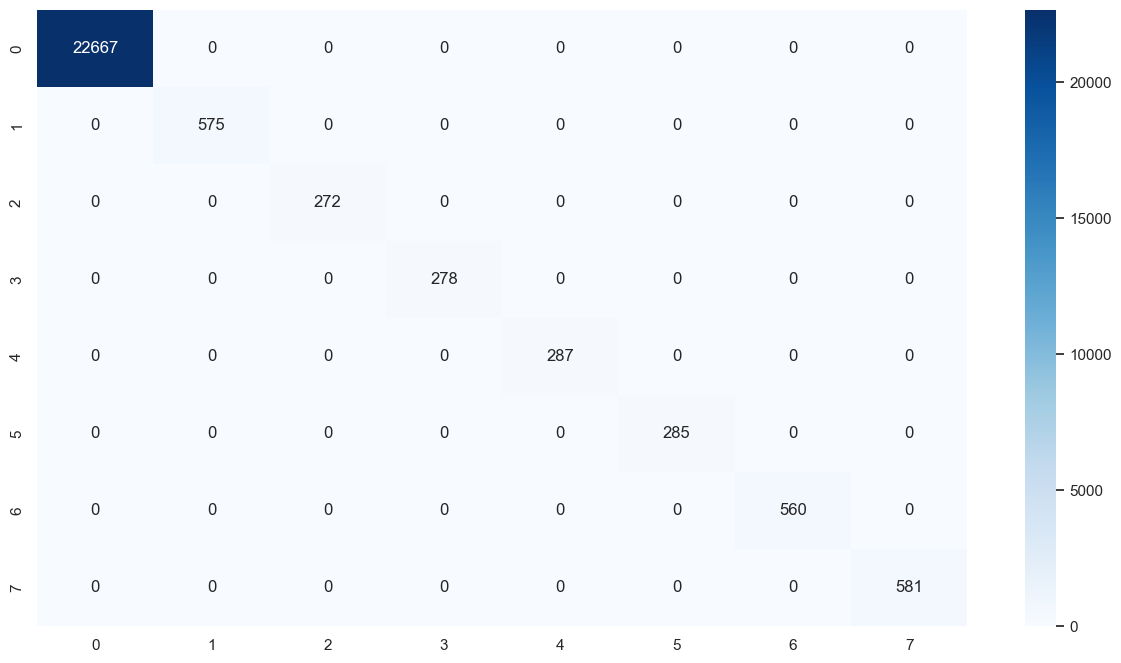

In [217]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = model.predict(X_test)
true_labels = y_test
model_matrix = confusion_matrix(true_labels, predictions)
model_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(model_report)

In [218]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

In [219]:
for column in test_df.columns[test_df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
# Preprocess the validation dataset, remember that here you don't have the labels
test_df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=926LEgkPthwZ7PmHZMGoNYkwKSJNYhpFedyp77pdt...,"Thu, 15 Dec 2022 00:25:58 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,401,"{""error"": ""Not a number failed to parse""}",None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=MLG1yMopd5OPm-zy-DX3n9z9ABcJJAFfcJzJ8U136...,"Thu, 15 Dec 2022 00:43:42 GMT",GET,http://127.0.0.1:5000/login/user?username=Matt...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=uGbYZiLHLJ4ad9euj-IKkG1ocXzyNmGrVFeBqdl59...,"Thu, 15 Dec 2022 00:46:38 GMT",GET,http://127.0.0.1:5000/static/download_txt/John...,,200 OK,application/json,87,200,"{""error"": ""File John.txtfile_id=KUef9zOM7k3S1N...",None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=lzQ5X_NFmKNO72S2OLs4IX7v0u8E1E-Tubuvf3SUR...,"Thu, 15 Dec 2022 00:08:10 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,66,200,"{""error"": ""File ../../../../../../../../etc/pa...",None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=xlKbor9ee37pO7PmCwlreAAyCQZxKzpjfH6irwCOK...,"Thu, 15 Dec 2022 00:02:22 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,106,200,text/html; charset=utf-8,username=gASVygAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None


In [220]:
# Preprocess the validation dataset, remember that here you don't have the labels

# test_df['request.url'] =  test_df['request.url'].str.slice(22)

test_df['Log4j'] = test_df.apply(lambda row: check_for_Log4j(row), axis=1)

test_df['SQL'] = test_df.apply(lambda row: check_for_SQL_injection(row), axis=1)

test_df['RCE'] = test_df.apply(lambda row: check_for_RCE(row), axis=1)

test_df['Cookie_Injection'] = test_df.apply(lambda row: check_for_Cookie_injection(row), axis=1)

test_df['Directory_Traversal'] = test_df.apply(lambda row: check_for_Directory_Traversal(row), axis=1)

test_df['Log_Forge'] = test_df.apply(lambda row: check_for_Log_Forge(row), axis=1)

test_df['XSS'] = test_df.apply(lambda row: check_for_XSS(row), axis=1)

test_df = vectorize_df(test_df)
test_df.head()

,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie,Log4j,SQL,RCE,Cookie_Injection,Directory_Traversal,Log_Forge,XSS
0,1,0,4,1,2,1,3511,0,7552,4,341,401,1138,0,14,2,0,0,0,0,0,0,0,0
1,1,0,2,1,2,1,8274,0,6789,4,181,401,217,0,14,2,0,0,0,0,0,0,0,0
2,1,0,4,1,1,1,20543,0,13728,0,605,200,672,0,14,2,0,0,0,0,0,0,0,0
3,1,0,1,1,2,1,17571,0,13278,0,516,200,222,0,14,2,0,0,0,0,0,1,0,0
4,1,0,3,1,1,1,21766,0,4975,0,11,200,131,34,14,2,0,0,0,0,1,0,0,0


In [221]:
# Predict with your model
X = test_df[features_list].to_numpy()
predictions = model.predict(X)

In [222]:
enc = LabelEncoder()
np.savetxt(f'results/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')